In [1]:
# ============================================================
# CNN Advanced Practice Notebook 03
# Grad-CAM (Explainable AI) on CIFAR-10
# ============================================================
# [KR]
# 목표:
# - CNN이 "어느 부분을 보고" 분류했는지 Grad-CAM으로 시각화한다.
# - 예측 클래스 기준 Grad-CAM과 정답 클래스 기준 Grad-CAM을 비교한다.
#
# [JP]
# 目的:
# - CNNが「画像のどの部分」に注目して分類したかをGrad-CAMで可視化する。
# - 予測クラス基準と正解クラス基準のGrad-CAMを比較する。
#
# 핵심 개념:
# - Grad-CAM: 특정 클래스 점수에 대한 마지막 Conv feature map의 기여도를 heatmap으로 표현
# - 마지막 Conv layer(last_conv): 공간 정보(어디를 봤는지)를 가진 마지막 특징 맵

In [2]:
# ------------------------------------------------------------
# 0) Library Import
# ------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

C:\Users\JA60301\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
# ------------------------------------------------------------
# 1) Data Load & Preprocess (CIFAR-10)
# ------------------------------------------------------------
# CIFAR-10: 32x32 RGB 이미지 / 10개 클래스
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 픽셀값 정규화 (0~255 -> 0~1)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# 라벨 shape: (N, 1) -> (N,)
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

In [4]:
# ------------------------------------------------------------
# 2) CNN Model Definition (마지막 Conv layer 이름 지정)
# ------------------------------------------------------------
# last_conv 레이어가 Grad-CAM의 기준 레이어가 된다.
inputs = tf.keras.Input(shape=(32, 32, 3))

# Conv1: 저수준 특징(엣지/색상)
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", name="conv1")(inputs)
x = tf.keras.layers.MaxPooling2D()(x)

# last_conv: 고수준 특징(부분/패턴) + Grad-CAM 기준 레이어
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", name="last_conv")(x)
x = tf.keras.layers.MaxPooling2D()(x)

# Classifier Head
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ------------------------------------------------------------
# 3) Model Training (실습용: epoch 적게)
# ------------------------------------------------------------
# 목적:
# - Grad-CAM 시각화를 위한 간단한 학습
# - 최고 성능이 목적은 아님
model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=128,
    verbose=1
)

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4195 - loss: 1.6162
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5508 - loss: 1.2741
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5990 - loss: 1.1398


In [6]:
# ------------------------------------------------------------
# 4) Grad-CAM용 cam_model 구성
# ------------------------------------------------------------
# cam_model은 입력을 넣으면
# - last_conv의 feature map
# - 최종 예측(softmax)
# 을 동시에 출력하도록 만든다.

# (관례) 모델을 한 번 호출해 그래프 확정 (일부 환경에서 layer 접근/GradientTape 안정성 향상)
_ = model(tf.zeros((1, 32, 32, 3)))

last_conv_layer = model.get_layer("last_conv")

cam_model = tf.keras.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.outputs[0]]
)

In [7]:
# ------------------------------------------------------------
# 5) Grad-CAM Heatmap 생성 함수
# ------------------------------------------------------------
def make_gradcam_heatmap(img_array, cam_model, class_idx=None):
    """
    img_array : (1, H, W, C) 형태의 입력 이미지
    class_idx : 보고 싶은 클래스 index
                - None이면 모델의 예측 클래스(argmax)를 사용
    return    : (h, w) heatmap (numpy)
    """

    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img_array)

        # class_idx가 없으면 예측 클래스 사용
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])

        # 선택된 클래스의 점수(score)
        loss = predictions[:, class_idx]

    # 선택된 클래스 점수에 대한 conv_outputs의 gradient 계산
    grads = tape.gradient(loss, conv_outputs)

    # 채널별 중요도: gradient를 spatial하게 평균내어 가중치로 사용 (Global Average Pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (channels,)

    # (1, h, w, c) -> (h, w, c)
    conv_outputs = conv_outputs[0]

    # 채널 가중합으로 heatmap 생성
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU: 양의 기여만 시각화
    heatmap = tf.maximum(heatmap, 0)

    # 정규화: 0~1
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

In [8]:
# ------------------------------------------------------------
# 6) Heatmap 시각화 함수 (원본/heatmap/overlay)
# ------------------------------------------------------------
def show_gradcam_on_image(img, heatmap, alpha=0.4):
    """
    img     : (H, W, 3) 원본 이미지
    heatmap : (h, w) Grad-CAM heatmap
    alpha   : overlay 투명도
    """

    # heatmap을 원본 이미지 크기로 resize
    heatmap_resized = tf.image.resize(
        heatmap[..., np.newaxis],
        (img.shape[0], img.shape[1])
    )
    heatmap_resized = tf.squeeze(heatmap_resized).numpy()

    plt.figure(figsize=(9, 3))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_resized, cmap="jet")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(img)
    plt.imshow(heatmap_resized, cmap="jet", alpha=alpha)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


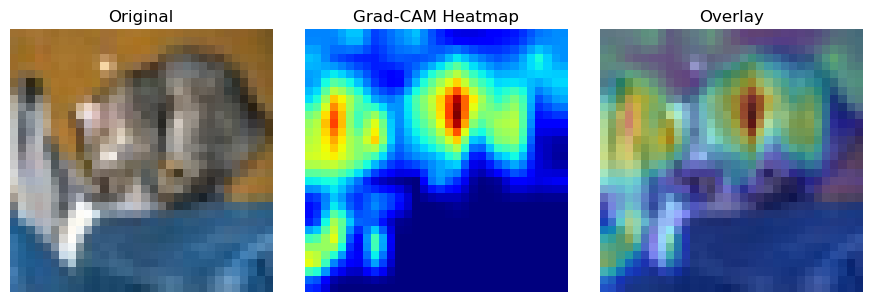

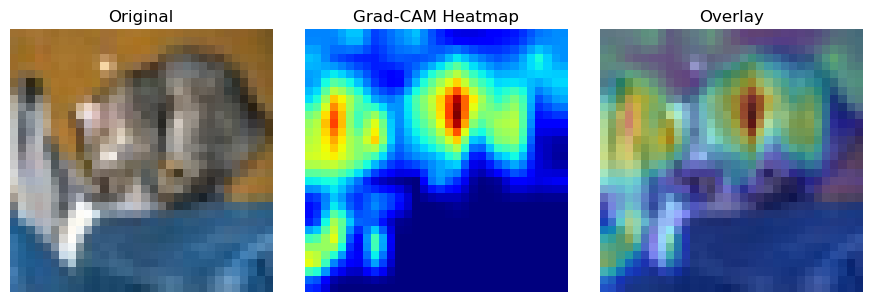

In [10]:
# ------------------------------------------------------------
# 7) Demo: 예측 클래스 vs 정답 클래스 Grad-CAM 비교
# ------------------------------------------------------------
# 테스트 이미지 1장 선택
idx = 0
img = x_test[idx]
img_array = np.expand_dims(img, axis=0)

# (1) 예측 클래스 기준 Grad-CAM
heatmap_pred = make_gradcam_heatmap(img_array, cam_model, class_idx=None)
show_gradcam_on_image(img, heatmap_pred)

plt.savefig("gradcam_predicted.png", dpi=300, bbox_inches="tight")
plt.close()

# (2) 정답 클래스 기준 Grad-CAM
true_class = int(y_test[idx])
heatmap_true = make_gradcam_heatmap(img_array, cam_model, class_idx=true_class)
show_gradcam_on_image(img, heatmap_true)

plt.savefig("gradcam_true.png", dpi=300, bbox_inches="tight")
plt.close()

In [ ]:
# ------------------------------------------------------------
# 8) Analysis Tips (보고서/과제용 포인트)
# ------------------------------------------------------------
# - 예측 클래스 기준 Grad-CAM:
#   모델이 "실제로 선택한" 판단 근거 시각화 (모델 관점)
# - 정답 클래스 기준 Grad-CAM:
#   정답을 강제로 목표로 했을 때, "정답 클래스에 도움이 되는 영역" 시각화
#
# - 두 heatmap이 다를 수 있는 이유:
#   모델이 틀렸거나(오답) / 애매한 클래스 간 혼동 / 배경에 과도하게 의존 등
#
# - last_conv를 바꾸면?
#   더 앞쪽 conv를 쓰면 heatmap이 더 로컬(저수준)해지고,
#   더 뒤쪽 conv를 쓰면 heatmap이 더 추상적(고수준)으로 나온다.